# 1D Helmholtz Multilevel Development: Repetitive; Local Coarsening Derivation
* Constant $k$.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.

In [57]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [40]:
# Fixed seed for reproducible results.
np.random.seed(1)

# Domain size.
n = 96
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
kh = helmholtz.analysis.ideal.find_singular_kh("5-point", n)[0]

repetitive = True

# Number of test vectors.  
ideal_tv = True  # False    # Use eigenvectors or not.
num_examples = 3
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls"
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513012


## Level 0->1 Coarsening

In [5]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, "5-point", n) #, bc="bloch")
# Use default Kacmzarz for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# TV and TV residual history.
x_log = []
r_log = []

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.323e+00                    4.471e-01    2.957
INFO     1     7.253e-01 (0.549) [0.549]    3.426e-01    2.120 (0.716)
INFO     2     4.196e-01 (0.579) [0.563]    2.960e-01    1.423 (0.670)
INFO     3     2.568e-01 (0.613) [0.580]    2.731e-01    0.945 (0.665)
INFO     4     1.728e-01 (0.673) [0.602]    2.604e-01    0.667 (0.706)
INFO     5     1.279e-01 (0.740) [0.627]    2.520e-01    0.510 (0.765)
INFO     6     1.027e-01 (0.803) [0.654]    2.458e-01    0.420 (0.824)
INFO     7     8.760e-02 (0.853) [0.679]    2.408e-01    0.365 (0.871)
INFO     8     7.778e-02 (0.888) [0.702]    2.365e-01    0.330 (0.904)
INFO     9     7.092e-02 (0.911) [0.723]    2.328e-01    0.306 (0.926)
INFO     10    6.578e-02 (0.927) [0.741]    2.295e-01    0.288 (0.940)
INFO     11    6.174e-02 (0.938) [0.757]    2.264e-01    0.274 (0.951)
INFO     12    5.846e-02 (0.946) [0.772]    2.236e-01    0.262 (0.958)
INFO 

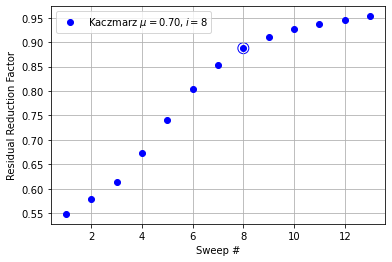

In [13]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95)
num_sweeps = method_info["Kaczmarz"][1]

In [41]:
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, num_sweeps))
    x = hm.setup.auto_setup.get_test_matrix(a, num_sweeps, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 3 ideal TVs


### Coarsening: Fixed (4/2)

In [42]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

Coarsening: a 4 nc 2 #windows 15 s [0.716 0.387 0.014 0.001]


,0,1,2,3,4,5,6,7,8,9
0,-0.43,-0.57,-0.56,-0.42,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.66,-0.24,0.25,0.67,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.43,-0.57,-0.56,-0.42,0.00,0.00
3,0.00,0.00,0.00,0.00,-0.66,-0.24,0.25,0.67,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.43,-0.57


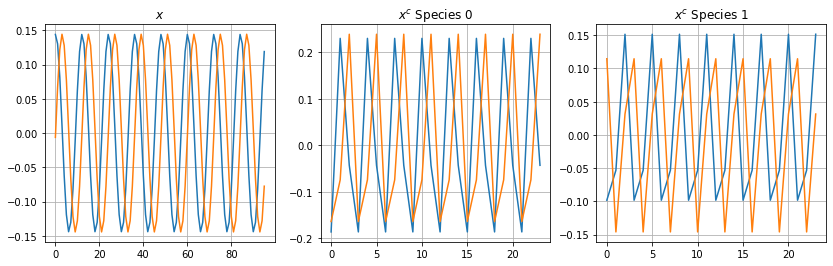

In [43]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [44]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.466 0.283 0.129 0.139 0.104 0.076 0.065 0.052]


### Interpolation $P = R^T$

In [62]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()
print(p.todense())

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(hm.repetitive.locality.create_two_level_hierarchy(
        kh, m * aggregate_size, r.asarray(), p, aggregate_size), nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "Two-level")).transpose()
display(conv)

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

[[-0.432 -0.661]
 [-0.566 -0.237]
 [-0.562  0.247]
 [-0.422  0.668]]


,1,2,3,4,5,6,7,8
Mock,0.47,0.28,0.13,0.14,0.10,0.08,0.07,0.05
Two-level,0.49,0.30,0.41,0.38,0.36,0.35,0.34,0.33


INFO     L2 projection norm 1.00 A*A' projection norm 2.84


This intepolation is good up to $\nu = 2$, conv $\approx 0.5$.

### Interpolation by LS Fitting

In [94]:
l2c = []
p_caliber = []
calibers = (2, 3, 4)
for caliber in calibers:
    #print("caliber", caliber)
    interpolation_method = "ls"
    neighborhood = "extended"

    p = hm.setup.auto_setup.create_interpolation(
        x, level.a, R, interpolation_method, aggregate_size=aggregate_size, nc=num_components, 
        neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
        caliber=caliber)

    # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
    #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
    #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
    #     _LOGGER.info(
    #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
    #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

    # Initial guess for interpoation: P = R^T on a single aggregate.
    #display(pd.DataFrame(p[:6, :6].todense()))

    two_level_conv = np.array([
        hm.repetitive.locality.two_level_conv_factor(hm.repetitive.locality.create_two_level_hierarchy(
            kh, n, R, p, aggregate_size), nu)[1]
         for nu in nu_values])
    l2c.append(two_level_conv)
    p_caliber.append(p)
    
conv = pd.DataFrame(np.array([mock_conv] + l2c).transpose(), 
                    index=nu_values, columns=("Mock",) + tuple("Caliber {}".format(caliber)
                                                              for caliber in calibers)).transpose()
display(conv)

INFO     caliber 2 error l2 [0.02] a [5.53e+12]
INFO     caliber 3 error l2 [0.01] a [4.22e+12]
INFO     caliber 4 error l2 [0.00] a [6.51e-01]


,1,2,3,4,5,6,7,8
Mock,0.47,0.28,0.13,0.14,0.10,0.08,0.07,0.05
Caliber 2,0.44,0.29,0.38,0.37,0.30,0.32,0.32,0.28
Caliber 3,0.53,0.27,0.26,0.28,0.23,0.23,0.23,0.22
Caliber 4,0.53,0.28,0.17,0.14,0.14,0.10,0.05,0.05


In [120]:
for caliber, p in zip(calibers, p_caliber):
#    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
#    display_html(styler._repr_html_(), raw=True)
    ml = hm.repetitive.locality.create_two_level_hierarchy(kh, n, R, p, None)
    ac = ml[1].a
    print("caliber {} nnz(P) {} nnz(A^1)/nnz(A^0) {:.2f}".format(caliber, p.nnz, ac.nnz / ml[0].a.nnz))
    display_df_side_by_side(pd.DataFrame(p[:6, :6].todense()),
                            pd.DataFrame(ac.todense()[:10,:10]), 
                        captions=("P", "A^1"))

caliber 2 nnz(P) 192 nnz(A^1)/nnz(A^0) 1.00


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 -0.43 
 -0.66 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.57 
 -0.24 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 -0.56 
 0.25 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 -0.42 
 0.67 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 -0.43 
 -0.66 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 -0.57 
 -0.24 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.13 
 -0.01 
 0.18 
 0.28 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.01 
 -1.20 
 -0.29 
 -0.44 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.18 
 -0.29 
 -0.13 
 -0.01 
 0.18 
 0.28 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.28 
 -0.44 
 -0.01 
 -1.20 
 -0.29 
 -0.44 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.18 
 -0.29 
 -0.13 
 -0.01 
 0.18 
 0.28 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.28 
 -0.44 
 -0.01 
 -1.20 
 -0.29 
 -0.44 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.18 
 -0.29 
 -0.13 
 -0.01 
 0.18 
 0.28 
 
 
 7 
 0.00 
 0.00 
 0.00 
 0.00 
 0.28 
 -0.44 
 -0.01 
 -1.20 
 -0.29 
 -0.44 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.18 
 -0.29 
 -0.13 
 -0.01 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.28 
 -0.44 
 -0.01 
 -1.20

caliber 3 nnz(P) 288 nnz(A^1)/nnz(A^0) 1.17


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 -0.45 
 -0.59 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.55 
 -0.30 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 -0.55 
 0.31 
 0.04 
 0.00 
 0.00 
 0.00 
 
 
 3 
 -0.44 
 0.59 
 -0.05 
 0.00 
 0.00 
 0.00 
 
 
 4 
 -0.05 
 0.00 
 -0.45 
 -0.59 
 0.00 
 0.00 
 
 
 5 
 0.04 
 0.00 
 -0.55 
 -0.30 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.08 
 -0.01 
 0.18 
 0.23 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.01 
 -0.99 
 -0.24 
 -0.35 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.18 
 -0.24 
 -0.08 
 -0.01 
 0.18 
 0.23 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.23 
 -0.35 
 -0.01 
 -0.99 
 -0.24 
 -0.35 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.18 
 -0.24 
 -0.08 
 -0.01 
 0.18 
 0.23 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.23 
 -0.35 
 -0.01 
 -0.99 
 -0.24 
 -0.35 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.18 
 -0.24 
 -0.08 
 -0.01 
 0.18 
 0.23 
 
 
 7 
 0.00 
 0.00 
 0.00 
 0.00 
 0.23 
 -0.35 
 -0.01 
 -0.99 
 -0.24 
 -0.35 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.18 
 -0.24 
 -0.08 
 -0.01 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.23 
 -0.35 
 -0.01 
 -0.99

caliber 4 nnz(P) 384 nnz(A^1)/nnz(A^0) 1.67


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 -0.38 
 -0.43 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.60 
 -0.40 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 -0.59 
 0.41 
 0.08 
 0.11 
 0.00 
 0.00 
 
 
 3 
 -0.37 
 0.44 
 -0.11 
 -0.17 
 0.00 
 0.00 
 
 
 4 
 -0.10 
 0.17 
 -0.38 
 -0.43 
 0.00 
 0.00 
 
 
 5 
 0.08 
 -0.11 
 -0.60 
 -0.40 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.04 
 -0.01 
 0.15 
 0.19 
 0.01 
 0.01 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.01 
 -0.77 
 -0.20 
 -0.25 
 -0.01 
 -0.01 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.15 
 -0.20 
 -0.04 
 -0.01 
 0.15 
 0.19 
 0.01 
 0.01 
 0.00 
 0.00 
 
 
 3 
 0.19 
 -0.25 
 -0.01 
 -0.77 
 -0.20 
 -0.25 
 -0.01 
 -0.01 
 0.00 
 0.00 
 
 
 4 
 0.01 
 -0.01 
 0.15 
 -0.20 
 -0.04 
 -0.01 
 0.15 
 0.19 
 0.01 
 0.01 
 
 
 5 
 0.01 
 -0.01 
 0.19 
 -0.25 
 -0.01 
 -0.77 
 -0.20 
 -0.25 
 -0.01 
 -0.01 
 
 
 6 
 0.00 
 0.00 
 0.01 
 -0.01 
 0.15 
 -0.20 
 -0.04 
 -0.01 
 0.15 
 0.19 
 
 
 7 
 0.00 
 0.00 
 0.01 
 -0.01 
 0.19 
 -0.25 
 -0.01 
 -0.77 
 -0.20 
 -0.25 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.01 
 -0.01 
 0.15 
 -0.20 
 -0.04 
 -0.01 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.01 
 -0.01 
 0.19 
 -0.25 
 -0.01 
 -0.77

In [121]:
# Coarse level with caliber = 4 has a lot of small entries.
pd.DataFrame(ac.todense())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,-0.04,-0.01,0.15,0.19,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,-0.01,0.15,-0.20
1,-0.01,-0.77,-0.20,-0.25,-0.01,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,-0.01,0.19,-0.25
2,0.15,-0.20,-0.04,-0.01,0.15,0.19,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,-0.01
3,0.19,-0.25,-0.01,-0.77,-0.20,-0.25,-0.01,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,-0.01
4,0.01,-0.01,0.15,-0.20,-0.04,-0.01,0.15,0.19,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.01,-0.01,0.19,-0.25,-0.01,-0.77,-0.20,-0.25,-0.01,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.01,-0.01,0.15,-0.20,-0.04,-0.01,0.15,0.19,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.01,-0.01,0.19,-0.25,-0.01,-0.77,-0.20,-0.25,-0.01,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.01,-0.01,0.15,-0.20,-0.04,-0.01,0.15,0.19,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.01,-0.01,0.19,-0.25,-0.01,-0.77,-0.20,-0.25,-0.01,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
